# Info
### : crawling한 기사들 중에서 짦은 시간 내에 신문사, 제목이 모두 일치한 기사들이 중복하여 올라온 것을 발견하였다. 아래의 코드는 중복되는 기사들의 공통점을 발견하기 위한 코드이다.

In [2]:
import pandas as pd
import glob

file_name = glob.glob('../article/headline_noun_keyword*')

keyword_df = []
for file in file_name:
    df = pd.read_pickle(file)
    keyword_df.append(df)

keyword_all = pd.concat(keyword_df, ignore_index = True)
keyword = keyword_all[keyword_all['week'] <= 807]

In [3]:
keyword = keyword.sort_values(by = 'date', ascending = True, ignore_index = True)

In [4]:
gu_name = ['강남구','강동구','강서구','강북구','관악구','광진구','구로구','금천구',
          '노원구','동대문구','도봉구','동작구','마포구','서대문구','성동구','성북구',
          '서초구','송파구','영등포구','용산구','양천구','은평구','종로구','중구','중랑구']

many = len(gu_name)

In [5]:
read_path = "../seoul_apt_trade_data/"

trade_df = pd.DataFrame()
for gu in gu_name:
    gu_df = pd.read_pickle(f"{read_path}{gu}_trade.pkl")
    trade_df = pd.concat([trade_df,gu_df])

In [6]:
trade_df = trade_df[trade_df['거래주'] < 808]

In [7]:
co_list = list(set(keyword['co']))

In [8]:
def find_same_title(df):
    weekly_same_title = {}

    for week in range(808):
        weekly_df = df[df['week'] == week]
        same_title = {}

        for title in weekly_df['headline']:
            if title in same_title:
                same_title[title] += 1
            else:
                same_title[title] = 1
        weekly_same_title[week] = same_title
    
    weekly_over2_title = {}

    for week in range(808):
        over2_title = {}
        for index, (title, count) in enumerate(weekly_same_title[week].items()):
            if count >= 2:
                over2_title[title] = count
        weekly_over2_title[week] = over2_title
    return weekly_over2_title

def find_same_title_index(df):
    weekly_same_title = {}

    for week in range(808):
        weekly_df = df[df['week'] == week]
        same_title = {}

        for title in weekly_df['headline']:
            if title in same_title:
                same_title[title] += 1
            else:
                same_title[title] = 1
        weekly_same_title[week] = same_title
    
    weekly_over2_title = {}

    for week in range(808):
        over2_title = {}
        for index, (title, count) in enumerate(weekly_same_title[week].items()):
            if count >= 2:
                over2_title[title] = index
        weekly_over2_title[week] = over2_title
    return weekly_over2_title

In [9]:
weekly_over2_title = find_same_title(keyword)

1. 단순 반복 타이틀 수 비교

In [10]:
df = pd.DataFrame({
    'week' : [i for i in range(808)],
    'count' : [sum(weekly_over2_title[i].values()) for i in range(808)]
})
df

,week,count
0,0,44
1,1,43
2,2,32
3,3,65
4,4,18
...,...,...
803,803,129
804,804,269
805,805,173
806,806,117


In [11]:
df['count'].sum()

72941

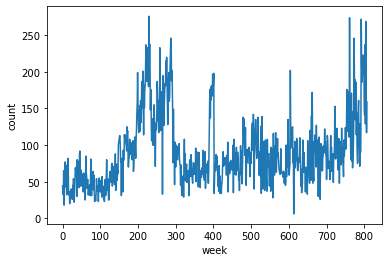

In [12]:
import matplotlib.pyplot as plt

plt.xlabel('week')
plt.ylabel('count')
plt.plot(df['count'])

1-2. 전체 신문사에대한 실수 확률

In [31]:
df["total_count"] = keyword.groupby(["week"])["co"].count()

In [14]:
df["weekly_mistake_per"] = df["count"]/df["total_count"]

In [15]:
mean_of_per = df["weekly_mistake_per"].mean()

In [16]:
mean_of_total = df["count"].sum()/df["total_count"].sum()

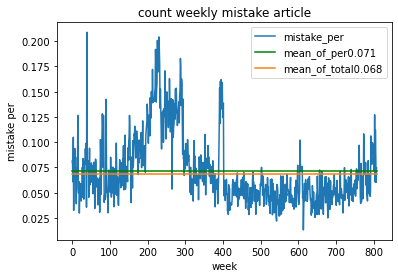

In [22]:
x = [i for i in range(808)]
plt.plot(df["weekly_mistake_per"], label = "mistake_per")
plt.plot(x,[mean_of_per for i in range(808)],c = 'g', label = f"mean_of_per{mean_of_per:0.3f}")
plt.plot(x,[mean_of_total for i in range(808)], label = f"mean_of_total{mean_of_total:0.3f}")
plt.title("count weekly mistake article")
plt.xlabel("week")
plt.ylabel("mistake per")
plt.legend()

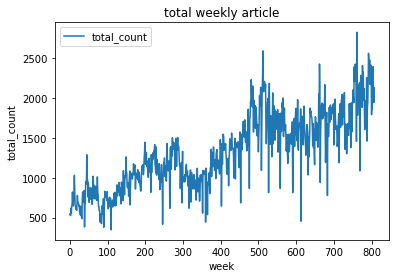

In [23]:
plt.plot(df["total_count"], label = 'total_count')
plt.title("total weekly article")
plt.xlabel('week')
plt.ylabel('total_count')
plt.legend()

2. 시기를 나누어 상관관게를 확인한다,

In [24]:
import scipy.stats as stats

print(stats.pearsonr(df["count"],df["total_count"]))
print(stats.spearmanr(df["count"],df["total_count"]))

(0.4576834318847363, 4.428449149666959e-43)
SpearmanrResult(correlation=0.532264364284355, pvalue=2.635286408233745e-60)


In [25]:
print(stats.pearsonr(df["count"][:400],df["total_count"][:400]))
print(stats.spearmanr(df["count"][:400],df["total_count"][:400]))

(0.7890539925284992, 3.062810223207073e-86)
SpearmanrResult(correlation=0.8347840086373196, pvalue=3.3531188679443652e-105)


In [26]:
print(stats.pearsonr(df["count"][400:],df["total_count"][400:]))
print(stats.spearmanr(df["count"][400:],df["total_count"][400:]))

(0.732449428285418, 8.774175423848631e-70)
SpearmanrResult(correlation=0.7211362716125127, pvalue=1.0555881864884197e-66)


In [27]:
gov = ['mh','mb','gh','ji']
time_range = {'mh': (0, 112), 'mb': (112, 373), 'gh': (373, 570), 'ji': (592, 808)}

In [28]:
gov_corel = {}
for g in gov:
    s, e = time_range[g]
    print(g)
    pearson, p_pval = stats.pearsonr(df["count"][s:e],df["total_count"][s:e])
    spearman, s_pval = stats.spearmanr(df["count"][s:e],df["total_count"][s:e])
    gov_corel[g] = (pearson,spearman)
    print(f'pearson: {pearson}, {p_pval}')
    print(f'spearman: {spearman}, {s_pval}')

mh
pearson: 0.39352887709890294, 1.766575576689218e-05
spearman: 0.34618609281976276, 0.00018483737309964868
mb
pearson: 0.8151386334175317, 2.3345326809210067e-63
spearman: 0.8392235984426974, 1.7630211809760743e-70
gh
pearson: 0.33426078320820934, 1.5825447541787987e-06
spearman: 0.4559713761967494, 1.6592808379955753e-11
ji
pearson: 0.7790210810856992, 2.8727719163075095e-45
spearman: 0.7472856632571186, 7.5075709924774e-40


In [29]:
gov_corel_df = pd.DataFrame(gov_corel)
gov_corel_df.index = ('pearson','spearman')
gov_corel_df

,mh,mb,gh,ji
pearson,0.393529,0.815139,0.334261,0.779021
spearman,0.346186,0.839224,0.455971,0.747286


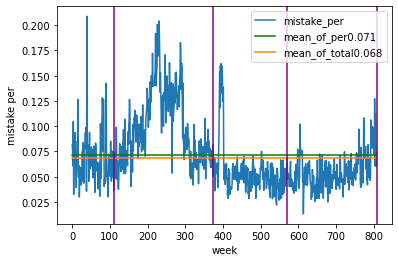

In [36]:
plt.plot(df["weekly_mistake_per"], label = "mistake_per")
plt.plot(x,[mean_of_per for i in range(808)],c = 'g', label = f"mean_of_per{mean_of_per:0.3f}")
plt.plot(x,[mean_of_total for i in range(808)], label = f"mean_of_total{mean_of_total:0.3f}")
for g in gov:
    plt.axvline(time_range[g][1], c = 'purple')
plt.xlabel("week")
plt.ylabel("mistake per")
plt.legend()

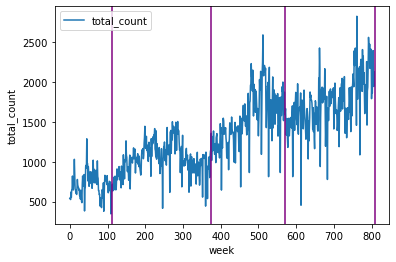

In [35]:
plt.plot(df["total_count"], label = 'total_count')
plt.xlabel('week')
plt.ylabel('total_count')
for g in gov:
    plt.axvline(time_range[g][1], c = 'purple')
plt.legend()

In [38]:
weekly_price = trade_df.groupby(['거래주'])['거래금액'].mean()

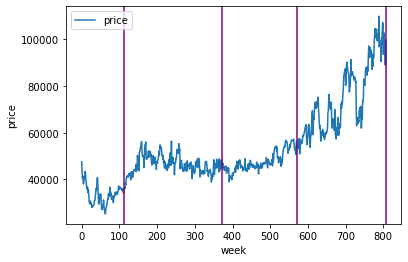

In [39]:
plt.plot(weekly_price, label = 'price')
for g in gov:
    plt.axvline(time_range[g][1], c = 'purple')
plt.xlabel("week")
plt.ylabel("price")
plt.legend()

3. 아파트 가격과 비교

In [40]:
up_rate = [0]
for i in range(1,len(weekly_price)):
    up_rate.append((weekly_price[i]-weekly_price[i-1])/weekly_price[i-1])

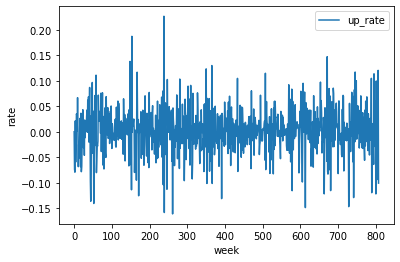

In [41]:
plt.plot(up_rate, label = 'up_rate')
plt.xlabel("week")
plt.ylabel("rate")
plt.legend()

In [42]:
new_df = pd.DataFrame({
    'weekly_mistake_per' : list(df["weekly_mistake_per"]),
    'up_rate' : up_rate
})

In [43]:
new_df[["weekly_mistake_per",'up_rate']].corr(method='pearson')

,weekly_mistake_per,up_rate
weekly_mistake_per,1.000000,-0.009408
up_rate,-0.009408,1.000000


In [45]:
up_rate = [0,0]
for i in range(2,len(weekly_price)):
    mean_of_three_week_price = (weekly_price[i]+weekly_price[i-1]+weekly_price[i-2])/3
    up_rate.append((weekly_price[i] - mean_of_three_week_price)/mean_of_three_week_price)

In [46]:
from sklearn import linear_model
import numpy as np

x1 = df["weekly_mistake_per"][:400].to_numpy()
y1 = df["total_count"][:400].to_numpy()
X1 = x1[:, np.newaxis]

x2 = df["weekly_mistake_per"][400:].to_numpy()
y2 = df["total_count"][400:].to_numpy()
X2 = x2[:, np.newaxis]

In [47]:
model_a = linear_model.LinearRegression()
model_a.fit(X1,y1)

model_b = linear_model.LinearRegression()
model_b.fit(X2,y2)

LinearRegression()

In [48]:
pred_a = model_a.predict([[min(x1)],[max(x1)]])
pred_b = model_b.predict([[min(x2)],[max(x2)]])

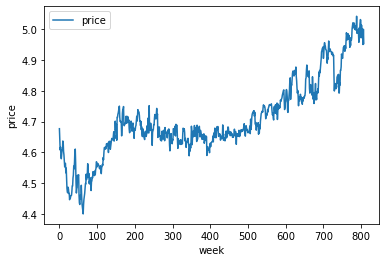

In [49]:
from math import log
plt.plot([log(price,10) for price in weekly_price], label = 'price')
plt.xlabel("week")
plt.ylabel("price")
plt.legend()

In [50]:
loged_price = [log(price,10) for price in weekly_price]

## 2. 반복 타이틀과 신문사

In [ ]:
co = list(set(co_list))

In [695]:
same_title_by_co = {}

for c in co:
    df = keyword[keyword['co'] == c]
    same_title_by_co[c] = find_same_title(df)

In [696]:
same_title_by_co_df = pd.DataFrame(same_title_by_co)

2.1 중복 타이틀이 발생하는 주

In [697]:
def count_true(co):
    count = 0

    for i in same_title_by_co_df[co]:
        if i != {}:
            count += 1

    return count

In [698]:
co_same_title_week_df = pd.DataFrame({
    "co" : co_list,
    "same_title_week" : [count_true(co) for co in co_list],
    "total_week" : [808] * len(co_list)
})

KeyError: 'SBS CNBC'

In [699]:
co_same_title_week_df

,co,same_title_week,total_week,same_per_total
0,매일경제,494,808,0.611386
1,파이낸셜뉴스,486,808,0.601485
2,한국경제TV,472,808,0.584158
3,연합뉴스,397,808,0.491337
4,헤럴드경제,311,808,0.384901
5,한국경제,279,808,0.345297
6,세계일보,261,808,0.323020
7,뉴스1,252,808,0.311881
8,서울경제,194,808,0.240099
9,이데일리,183,808,0.226485


In [233]:
co_same_title_week_df['same_per_total'] = co_same_title_week_df['same_title_week']/co_same_title_week_df['total_week']

In [234]:
co_same_title_week_df = co_same_title_week_df[co_same_title_week_df['same_title_week'] > 0]

In [235]:
co_same_title_week_df = co_same_title_week_df.sort_values(by = ['same_per_total'], ascending = False, ignore_index = True)

In [236]:
co_same_title_week_df

,co,same_title_week,total_week,same_per_total
0,매일경제,494,808,0.611386
1,파이낸셜뉴스,486,808,0.601485
2,한국경제TV,472,808,0.584158
3,연합뉴스,397,808,0.491337
4,헤럴드경제,311,808,0.384901
5,한국경제,279,808,0.345297
6,세계일보,261,808,0.323020
7,뉴스1,252,808,0.311881
8,서울경제,194,808,0.240099
9,이데일리,183,808,0.226485


In [578]:
per = 0.07

co_same_title_week_df_selected = co_same_title_week_df[co_same_title_week_df['same_per_total'] >= per]
co_same_title_week_df_selected

,co,same_title_week,total_week,same_per_total
0,매일경제,494,808,0.611386
1,파이낸셜뉴스,486,808,0.601485
2,한국경제TV,472,808,0.584158
3,연합뉴스,397,808,0.491337
4,헤럴드경제,311,808,0.384901
5,한국경제,279,808,0.345297
6,세계일보,261,808,0.323020
7,뉴스1,252,808,0.311881
8,서울경제,194,808,0.240099
9,이데일리,183,808,0.226485


In [579]:
selected_co_list = list(co_same_title_week_df_selected['co'])

2.1 중복 타이틀과 전체 타이들 비교

In [580]:
def count_same_title(series):
    result = []
    for i in range(808):
        result.append(sum(series[i].values()))
    return result

In [581]:
co_same_title_week_df_selected["same_title"] = [sum(count_same_title(same_title_by_co_df.loc[:,co])) for co in selected_co_list]

/tmp/ipykernel_111459/2709816432.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  co_same_title_week_df_selected["same_title"] = [sum(count_same_title(same_title_by_co_df.loc[:,co])) for co in selected_co_list]


In [582]:
co_same_title_week_df_selected['total_title'] = [keyword[keyword['co'] == co].describe().loc['count','week'] for co in co_same_title_week_df_selected['co']]

/tmp/ipykernel_111459/2910536685.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  co_same_title_week_df_selected['total_title'] = [keyword[keyword['co'] == co].describe().loc['count','week'] for co in co_same_title_week_df_selected['co']]


In [583]:
co_same_title_week_df_selected['same_per_total_title'] = co_same_title_week_df_selected['same_title']/co_same_title_week_df_selected['total_title']

/tmp/ipykernel_111459/1177378092.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  co_same_title_week_df_selected['same_per_total_title'] = co_same_title_week_df_selected['same_title']/co_same_title_week_df_selected['total_title']


In [584]:
co_same_title_week_df_selected

,co,same_title_week,total_week,same_per_total,same_title,total_title,same_per_total_title
0,매일경제,494,808,0.611386,3564,111656.0,0.031919
1,파이낸셜뉴스,486,808,0.601485,3973,96791.0,0.041047
2,한국경제TV,472,808,0.584158,7232,64141.0,0.112752
3,연합뉴스,397,808,0.491337,7039,50657.0,0.138954
4,헤럴드경제,311,808,0.384901,2100,63949.0,0.032839
5,한국경제,279,808,0.345297,1160,70121.0,0.016543
6,세계일보,261,808,0.323020,5451,24205.0,0.225201
7,뉴스1,252,808,0.311881,2212,19795.0,0.111745
8,서울경제,194,808,0.240099,592,53151.0,0.011138
9,이데일리,183,808,0.226485,691,78315.0,0.008823


In [660]:
sum(co_same_title_week_df_selected['total_title'])

917397.0

In [662]:
list(co_same_title_week_df_selected['co'])

['매일경제',
 '파이낸셜뉴스',
 '한국경제TV',
 '연합뉴스',
 '헤럴드경제',
 '한국경제',
 '세계일보',
 '뉴스1',
 '서울경제',
 '이데일리',
 '머니투데이',
 '헤럴드POP',
 '아시아경제',
 '경향신문',
 'MBN',
 '한겨레',
 '뉴시스',
 '조선비즈']

In [585]:
same_title_by_co_df

,SBS CNBC,중앙SUNDAY,서울경제,TV조선,쿠키뉴스,정책브리핑,한겨레21,JTBC,중앙일보,YTN 현장생중계,...,스포츠서울,스포츠조선,매일경제,헤럴드POP,국민일보,채널A,YTN,머니투데이,연합뉴스TV,뉴스1
0,{},{},{},{},{},{},{},{},{},{},...,{},{},"{'양도세 부담 덜자 하반기 매물 늘듯': 2, '전문기관이 예상한 올해 부동산시장...",{},{},{},{},{},{},{}
1,{},{},"{'이제 땅값 오르나 들뜬 주민들': 2, '대우건설 나이지리아서 8억弗 수주': 2}",{},{},{},{},{},{},{},...,{},{},"{'행정도시 보상협의 순풍': 2, '관심지역 조치원 전체 아파트촌 변신': 2, ...",{},{},{},{},{},{},{}
2,{},{},{},{},{},{},{},{},{},{},...,{},{},{},{},{},{},{},{},{},{}
3,{},{},"{'신도시도 수출 건설 韓流': 2, '해외 주택사업 10년만에 다시 활짝': 2}",{},{},{},{},{},{},{},...,{},{},"{'아파트 없이 공원만 짓는 재개발': 2, '재건축 악재 나오면 폭락 가능성': ...",{},{},{},"{'주먹구구 생애 첫 주택대출': 2, '판교분양 모델하우스 없이 3월말 청약 시작...","{'전원주택용지 구입 이런 것은 아세요': 2, '용인 동백지구 1만5000가구 입...",{},{}
4,{},{},{},{},{},{},{},{},{},{},...,{},{},{'판교 단지별로 차별화 뚜렷': 2},{},{},{},{},{},{},{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
803,{},{},{'부동산업 新舊 갈등 빅밸류 감평협회 고발 1년만에 판정승': 2},{},{},{},{},{},{},{},...,{},{},{},{},{},{},{},{},{},"{'임대차 신고제 교육받아요': 2, '전·월세신고제 시행 D7': 2, '임대차 ..."
804,{},{},"{'SK에코플랜트 폐기물 처리기업 4곳 인수': 2, 'DL이앤씨 中 수처리기업 U...",{},{},{},{},{},{},{},...,{},{},{},{},{},{},{},{},{},"{'6월부터 유주택자 과세 강화': 2, '다가오는 부동산시장 운명의 날': 2, ..."
805,{},{},{},{},{},{},{},{},{},{},...,{},{},{},{},{},{},{},{},{},"{'노형욱 장관 LH혁신방안 대국민 브리핑': 4, 'LH 혁신안 브리핑 참석하는 ..."
806,{},{},{},{},{},{},{},{},{},{},...,{},{},{},{},{},{},{},{},{},{'국토부 전국 해체공사 일제 점검': 2}


In [586]:
headline_index = find_same_title_index(keyword)

In [587]:
def sum_title(week, title_list):
    result = []
    title_list_size = len(title_list)
    for i in range(title_list_size):
        result += list(keyword.loc[headline_index[week][title_list[i]], ['pos']])
    return result

def extract_same_title(series):
    result = {}
    for i in range(808):
        result[i] = sum_title( i, list(series[i].keys()))
    return result

In [588]:
same_title_extract = {}

for co in selected_co_list:
    same_title_extract[co] = extract_same_title(same_title_by_co_df.loc[:,co])

In [589]:
def sum_list(pos_list):
    result = []
    if pos_list == []:
        return result
    for i in range(len(pos_list)):
        result += pos_list[i]
    return result

In [590]:
for co in selected_co_list:
    for i in range(808):
        same_title_extract[co][i] = sum_list(same_title_extract[co][i])

In [591]:
pd.DataFrame(same_title_extract)

,매일경제,파이낸셜뉴스,한국경제TV,연합뉴스,헤럴드경제,한국경제,세계일보,뉴스1,서울경제,이데일리,머니투데이,헤럴드POP,아시아경제,경향신문,MBN,한겨레,뉴시스,조선비즈
0,"[양도세, 부담, 하반기, 매물, 민간, 최대, 복합, 시설, 조성, 추병직, 건,...","[부동산, 학과, 내공, 부동산, 세무, 상담, 년, 전, 매입, 건물, 유흥주, ...",[],"[개정, 종, 부세, 양도세, 시행령, 세금]",[],"[은, 마아, 파트, 용적]","[결혼, 노부모, 경우, 종부, 합산, 과세, 년, 간, 제외, 사무실, 분기, 연...",[],[],[],[],[],[],"[용인, 분양, 봇물, 판교, 서울, 재건축, 아파트, 값, 주, 상승]","[서초구, 아파트, 평균, 평, 전국, 최고, 공인, 중개사, 누구, 응시, 가능,...",[],[],[]
1,"[경제, 영토, 해외, 건설, 업체, 오, 일, 달러, 덕분, 전문, 기관, 작년,...",[],[],[],[],"[도시, 땅, 업체, 소송, 불사, 아파트, 품질, 등급]","[아파트, 품질, 중개업, 소, 경매, 업체, 경매, 대행, 준비, 잰걸음, 외국, 집]",[],"[노무현, 정부, 년, 이것, 부동산, 정책, 각론, 문제, 압구정동, 아파트, 값...","[외국, 집]",[],[],[],"[주공, 판교, 중대, 턴키, 공사, 발주, 압구정동, 아파트, 값, 상승, 위]","[청약, 유망, 지역, 집중, 분석, 주목, 만, 지방, 택지, 지구, 끝]","[경매, 전문가, 고급, 과정, 디지털, 태인, 수강, 모집]",[],[]
2,[],"[새해, 분양, 진주, 문산, 에이, 원, 채, 방문객, 러시, 판교, 중대, 아파...",[],[],[],"[보유, 아파트, 주택, 보증, 전자, 공매, 건설, 문화, 포럼, 일, 개최]","[올해, 집값, 하향, 안정세, 부동산, 학과, 내공]",[],[],[],[],[],[],[],"[작년, 전국, 집값, 전세, 값, 상승]",[],[],[]
3,"[재테크, 주택, 원가, 연동, 적용, 전매, 최장, 년, 제한, 판교, 도시, 입...",[],[],"[행자부, 종부, 관련, 강남구, 특별, 감사, 판교, 가구, 분양, 차질, 우려,...","[새해, 부동산, 제도]","[집값, 금리, 추천, 매물, 제주, 평, 전원, 주택지, 천만, 원, 서울시, 뉴...",[],[],"[인천, 송도, 국제, 도시, 층, 업무, 복합, 빌딩, 건설, 체감, 경기]",[],"[발코니, 입주, 전, 개조, 세금, 발코니, 개조, 기존, 아파트, 불법, 개조,...",[],[],[],"[해외, 부동산, 투자, 열기, 급랭, 서초동, 승, 스타, 갤러리, 분양]",[],[],[]
4,"[부동산, 시장, 키워드, 뉴타운]",[],[],[],[],[],"[아파트, 급증, 전체, 주택, 차지]",[],[],[],[],[],[],[],[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
803,[],"[서울시, 송파, 도시, 연기, 공급, 과잉, 지연, 주장]",[],"[시황, 매매, 강동구, 재건축, 상승세, 이촌, 서빙고, 만, 평, 개발, 확정,...","[농지, 전용, 부담금, 최고, 배, 인상]",[],[],"[추천, 매물, 제주, 평, 전원, 주택지, 천만, 원, 중랑구, 중화, 뉴타운, ...","[건축, 규제, 필지, 단위, 대지, 단위, 변경]",[],[],[],[],[],[],[],[],[]
804,[],"[도로, 아파트, 시행, 사, 손, 배, 책임, 서울, 빌딩, 공실, 분기, 하락]",[],"[청약, 유망, 지역, 집중, 분석, 판교, 도시, 오창, 난개발, 지자체, 간, ...","[행정, 도시, 보상, 협의, 순풍, 남양주, 별내, 보상, 마찰, 주민, 대부분,...",[],[],"[대책, 후속, 법안, 통과, 절세, 요령, 주택, 거래, 신고, 유지, 거래, 신...","[지구, 단위, 계획, 기반, 시설, 부담, 구역, 지정, 동시, 건축, 제한, 수...",[],[],[],[],[],[],[],[],[]
805,[],"[주간, 시세, 서울, 집값, 상승, 개월, 만, 최고, 판교, 중, 소형, 분양,...",[],"[강원도, 설악, 현대, 만, 원, 회원, 모집, 가구, 이상, 아파트, 성능, 등...","[월, 전국, 가구, 분양]",[],[],"[청약, 통장, 판교, 도시, 공략, 법, 추천, 물건, 베스트, 용인, 평, 억,...",[],[],[],[],[],[],[],[],[],[]
806,[],"[부동산, 년, 유망, 투자]",[],"[주공, 만, 가구, 공급, 도시, 형평, 아파트, 연초, 대비, 시세, 급등, 강...","[생애, 주택, 대출]",[],[],"[올해, 집값, 전셋값, 국토, 硏]",[],[],[],[],[],[],[],[],[],[]


In [592]:
token_co_data = []

for co in selected_co_list:
    co_data = []
    for i in range(808):
        co_data += same_title_extract[co][i]
    token_co_data.append(co_data)

In [593]:
min_c_list = [10,25,50,75,100]

2021-10-15 11:25:53,105 : INFO : collecting all words and their counts
2021-10-15 11:25:53,106 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2021-10-15 11:25:53,122 : INFO : collected 2290 word types and 18 unique tags from a corpus of 18 examples and 98237 words
2021-10-15 11:25:53,123 : INFO : Creating a fresh vocabulary
2021-10-15 11:25:53,129 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=10 retains 1449 unique words (63.275109170305676%% of original 2290, drops 841)', 'datetime': '2021-10-15T11:25:53.129912', 'gensim': '4.1.2', 'python': '3.8.11 (default, Aug  3 2021, 15:09:35) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.0-84-generic-x86_64-with-glibc2.17', 'event': 'prepare_vocab'}
2021-10-15 11:25:53,131 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=10 leaves 94857 word corpus (96.55934118509319%% of original 98237, drops 3380)', 'datetime': '2021-10-15T11:25:53.131049', 'gensim': '4.1.2', 'python': '3.8.11 (default, Au

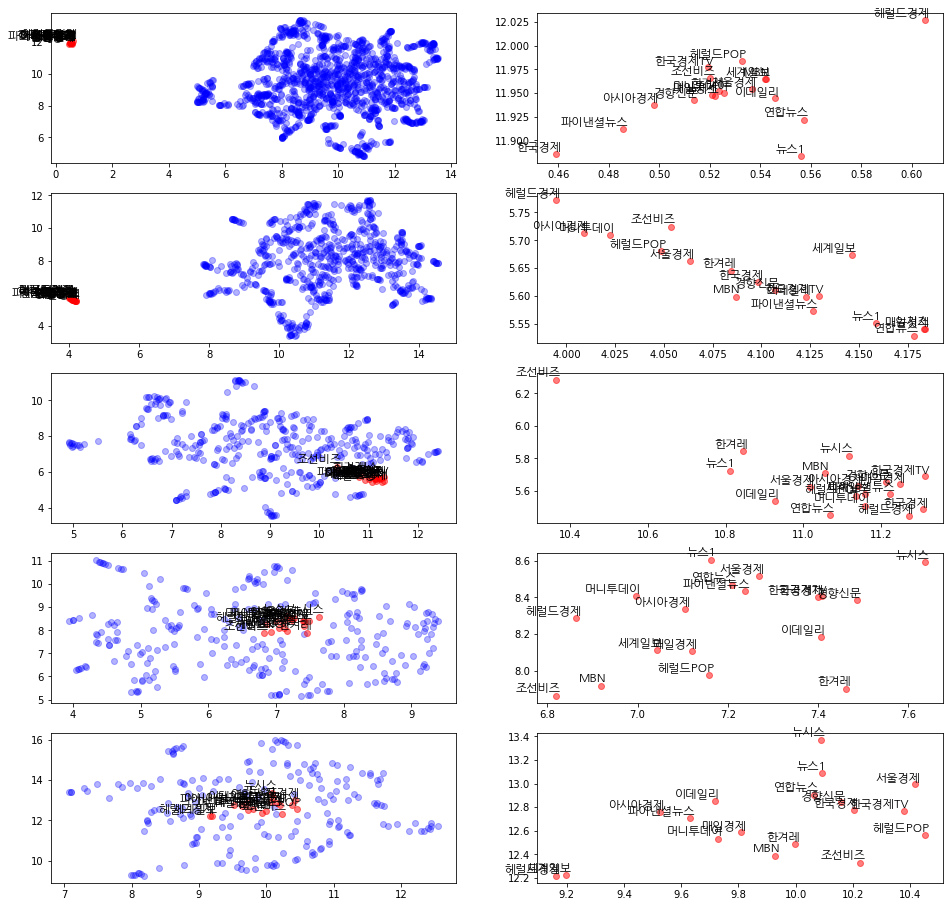

In [738]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import logging
import umap.umap_ as umap
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
fontprop = fm.FontProperties(fname=font_path, size=12)

#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

row = 0

#co_vec_03 = {}
co_vec_007 = {}

plt.figure(figsize=(16, 16))
for min_c in min_c_list:
    documents = [TaggedDocument(token_co_data[i], [doc]) for i,doc in enumerate(selected_co_list)]
    model = Doc2Vec(documents, vector_size=100, window=8, min_count=min_c, workers=10, epochs=10)

    labels = []
    tokens = []
    words_dv = list(model.dv.index_to_key)
    words_wv = list(model.wv.index_to_key)
    for word in words_dv:
        tokens.append(model.dv[word])
        labels.append(word)
    for word in words_wv:
        tokens.append(model.wv[word])
        labels.append(word)

    co_many = len(selected_co_list)

    reducer = umap.UMAP()
    embedding = reducer.fit_transform(tokens)
    embedding.shape
    
    ax1 = plt.subplot(len(min_c_list),2,row*2+1)
    
    for i in range(embedding.shape[0]):
        if labels[i] in words_wv:
            color='b'
            ax1.scatter(embedding[i,0],embedding[i,1], color = color, alpha=0.3)

    X = embedding[:co_many,0]
    Y = embedding[:co_many,1]
    L = labels[:2]

    ax1.scatter(X,Y, c='r', alpha=0.5)

    for i in range(co_many):
        ax1.annotate(labels[i],
                     xy=(embedding[i,0],embedding[i,1]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom', fontproperties=fontprop)
    #plt.savefig(f"./image_files/doc2vec_{per}_{min_c}.png")
    
    ax2 = plt.subplot(len(min_c_list),2,row*2+2) 
    X = embedding[:co_many,0]
    Y = embedding[:co_many,1]
    L = labels[:co_many]

    ax2.scatter(X,Y, c='r', alpha=0.5)

    for i in range(co_many):
        ax2.annotate(labels[i],
                     xy=(embedding[i,0],embedding[i,1]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom', fontproperties=fontprop)
    #plt.savefig(f"./image_files/co_doc2vec_{per}_{min_c}.png")
    
    #co_vec_03[min_c] = (X,Y,L)
    co_vec_007[min_c] = (X,Y,L)
    
    row += 1
    
plt.savefig(f"./image_files/co_doc2vec_{per}.png")
plt.show()

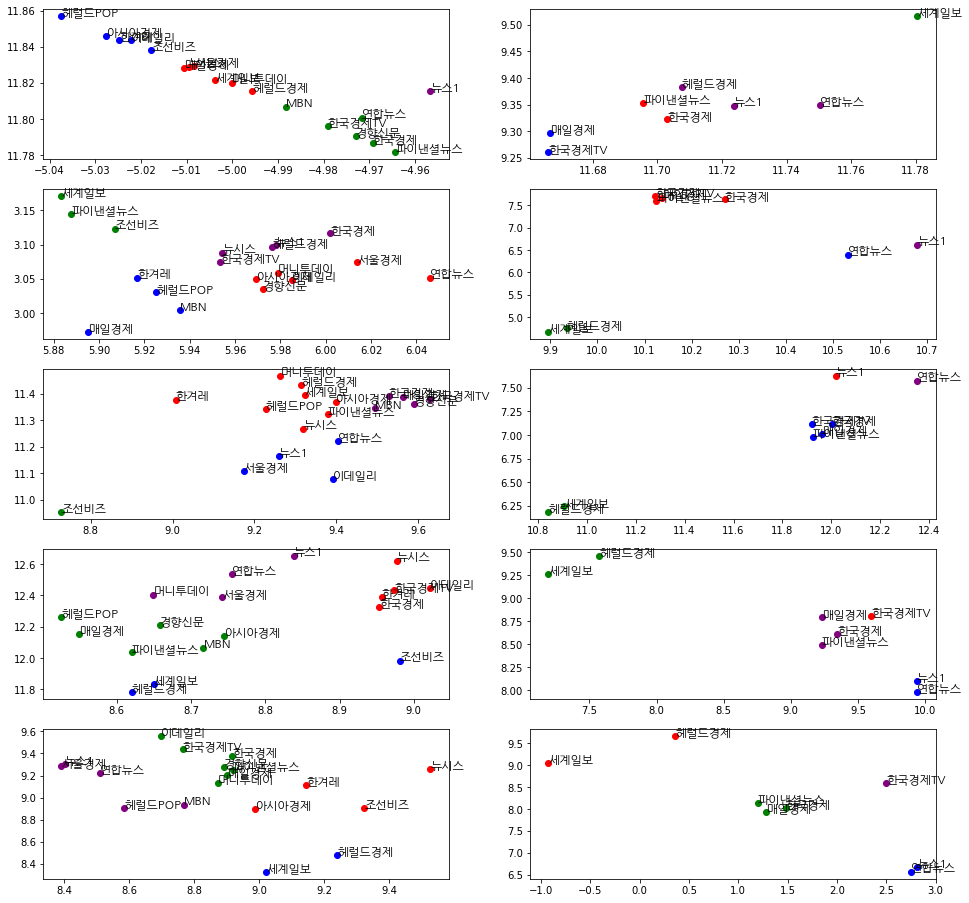

In [659]:
from sklearn.cluster import KMeans
import numpy as np

colors = {0:'r',1:'g',2:'b', 3:'purple'}

plt.figure(figsize=(16, 16))

co_cluster = {}

row = 0
for min_c in min_c_list:
    X007 = [[co_vec_007[min_c][0][i],co_vec_007[min_c][1][i]] for i in range(18)]
    X03 = [[co_vec_03[min_c][0][i],co_vec_03[min_c][1][i]] for i in range(8)]
    X007 = np.array(X007)
    X03 = np.array(X03)
    kmeans007 = KMeans(n_clusters=4).fit(X007)
    kmeans03 = KMeans(n_clusters=4).fit(X03)
    pred_007 = kmeans007.predict(X007)
    pred_03 = kmeans03.predict(X03)

    ax1 = plt.subplot(len(min_c_list),2,row*2+1)
    for i in range(18):
        x = X007[i][0]
        y = X007[i][1]
        ax1.scatter(x, y, c = colors[pred_007[i]])
        ax1.text(x,y,co_vec_007[min_c][2][i], fontproperties=fontprop)
        
    ax2 = plt.subplot(len(min_c_list),2,row*2+2)
    for i in range(8):
        x = X03[i][0]
        y = X03[i][1]
        ax2.scatter(x, y, c = colors[pred_03[i]])
        ax2.text(x,y,co_vec_03[min_c][2][i], fontproperties=fontprop)

    row += 1
    
plt.savefig(f"./image_files/co_doc2vec_cluster.png")
plt.show()

In [656]:
company_cluster_all = {0: ['이데일리', '문화일보', '국민일보', '매일신문', '아이뉴스24', '데일리안', '한국경제TV'],
 1: ['강원일보', '동아일보', '한겨레'],
 2: ['파이낸셜뉴스', '헤럴드경제', '머니투데이', '한국경제', '매일경제', '세계일보', '서울경제'],
 3: ['경향신문', '연합뉴스', '노컷뉴스']}